# 2D Kalman filter

Example here is an object moving in 2D. We sample accelerations and positions with noise and want improved position. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import inv
import scipy.integrate as spi 

g = 9.81


# Data generation
We'll generate this in advance and just sample. 

Text(0.5, 0, 'X [m]')

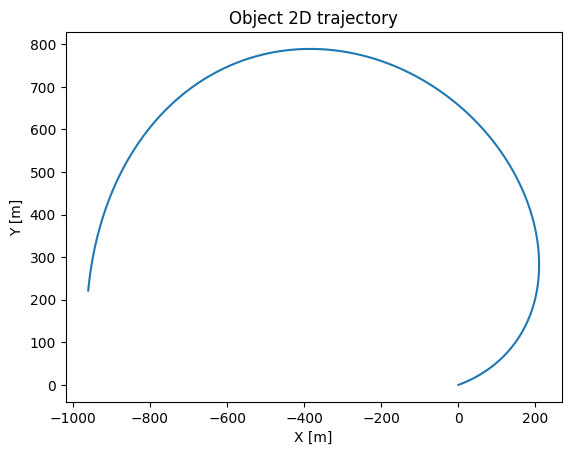

In [54]:
dt = 0.1
n_meas = 300

time = np.arange(0, n_meas)*dt

acceleration_x = -np.sin(2*np.pi*time/50 + np.pi/4)*10
acceleration_y =  np.cos(2*np.pi*time/50 + np.pi/6)*10

velocity_x     = spi.cumtrapz(acceleration_x, dx=dt, initial=0)+60
velocity_y     = spi.cumtrapz(acceleration_y, dx=dt, initial=0)+20

position_x = spi.cumtrapz(velocity_x, dx=dt, initial=0)
position_y = spi.cumtrapz(velocity_y, dx=dt, initial=0)

def gen_noisy_accel(sample_number):

    px = 12 * np.random.randn(1, 1)
    py = 12 * np.random.randn(1, 1)

    ax = 4 * np.random.randn(1, 1)
    ay = 4 * np.random.randn(1, 1)

    z = np.vstack([ position_x[sample_number]+px,
                    position_y[sample_number]+py, 
                    acceleration_x[sample_number]+ax, 
                    acceleration_y[sample_number]+ay])

    return dt, z

plt.plot(position_x, position_y)
plt.title('Object 2D trajectory')
plt.ylabel('Y [m]')
plt.xlabel('X [m]')


In [55]:

class kalman():

    def __init__(self, meas_fcn):
         
        self.samplesTaken = 0
        self.meas_fcn = meas_fcn

    def getMeasurement(self):

        self.dt, self.z = self.meas_fcn(self.samplesTaken)      
        self.samplesTaken += 1
        
    
    def filter(self):
        # Initialize State

        if self.samplesTaken == 1:
            # n = 3  [length of state vector]
            # m = 1  [length of measurement vector]
            
            # n x 1
            self.x = np.array([[0],     # Initial guess of p_x
                               [0],     # Initial guess of p_y
                               [0],     # Initial guess of velocity_x
                               [0],     # Initial guess of velocity_y
                               [0],     # Initial guess of acceleration_x
                               [0]])    # Initial guess of acceleration_y

            # n x n
            self.P = np.eye(6)*5  # aposteriori estimate of the covariance
                               
            
            # n x n
            self.A = np.array([[1,  0, dt,  0, 0,  0], # State transition matrix - i.e. physical model
                               [0,  1,  0,  dt, 0,  0],
                               [0,  0,  1,  0,  dt, 0],
                               [0,  0,  0,  1,  0,  dt],
                               [0,  0,  0,  0,  1,  0 ],
                               [0,  0,  0,  0,  0,  1 ]])
            
            # m x n # State to measurement operator (excluding the measurement noise part)
            self.H = np.array([ [1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1]]) 
                               
            # n x m
            self.HT = self.H.T
            
            # m x m
            self.R = np.eye(4)*10    # Measurement noise covariance matrix 
            
            # n x n
            self.Q = np.diag([1, 1, 3, 3, 2, 2])        # Physical model covariance matrix 
            
        ######################################################
        ## Forecast step
        ## Apriori estimate from your model and previous state
        ######################################################

        # Use model and last state to estimate next state
        x_p = self.A.dot(self.x)
        
        # Predict Covariance Forward
        # Use model and last cov matrix to estimate next cov matrix
        P_p = self.A.dot(self.P).dot(self.A.T) + self.Q
        
        ####################################################
        ## Analysis step
        ## Measurement update step
        ## Measurement update equations
        ####################################################

        # Compute Kalman Gain
        S = self.H.dot(P_p).dot(self.HT) + self.R
        K = P_p.dot(self.HT)@inv(S)

        # Calculate innovation
        observable_part_of_prior = self.H.dot(x_p)   
        residual = self.z - observable_part_of_prior # d, observational increment, innovation

        # Estimate state
        self.x   = x_p + K@residual

        # Estimate Covariance
        # Update covariance for the next step
        self.P = P_p - K.dot(self.H).dot(P_p)
        
        # return [self.x[0], self.x[1], self.P]

In [56]:
def testFilter(meas_fcn, n_meas):
    
    t = np.linspace(0, 10, num=n_meas)
    
    mykalman = kalman(meas_fcn)

    time = np.array([])
    z = np.zeros((4, 0))
    x  = np.zeros((6, 0))
    
    posBound3Sigma = []

    for k in range(0, n_meas):

        # New measurement         
        m = mykalman.getMeasurement()

        # Call Filter and return new State
        f = mykalman.filter()
        
        posVar = mykalman.P

        # print(z.shape)
        # print(mykalman.z.shape)
        time    = np.hstack([time, np.array(k)])
        z       = np.hstack([z,  mykalman.z])

        # print(x.shape)
        # print(mykalman.x.shape)
        x       = np.hstack([x,  mykalman.x])

        posBound3Sigma.append(3*np.sqrt(posVar[0][0]))
        
        # measDifPos.append(mykalman.z        - mykalman.currentPosition)
        # estDifPos.append(currentPositionEst - mykalman.currentPosition)
        
    return time, z, x, posBound3Sigma, mykalman



In [57]:
mykalman = testFilter(gen_noisy_accel, n_meas)
f = mykalman.filter()

self = mykalman

x_p = self.A.dot(self.x)

P_p = self.A.dot(self.P).dot(self.A.T) + self.Q
S = self.H.dot(P_p).dot(self.HT) + self.R

K = P_p.dot(self.HT)@inv(S)

observable_part_of_prior = self.H.dot(x_p)   
residual = self.z - observable_part_of_prior # d, observational increment, innovation

print(x_p.shape)
print(K.shape)
print(observable_part_of_prior.shape)
print(self.z.shape)

x_p + K@residual


print(S.shape)

1/S
inv(S)


AttributeError: 'tuple' object has no attribute 'filter'

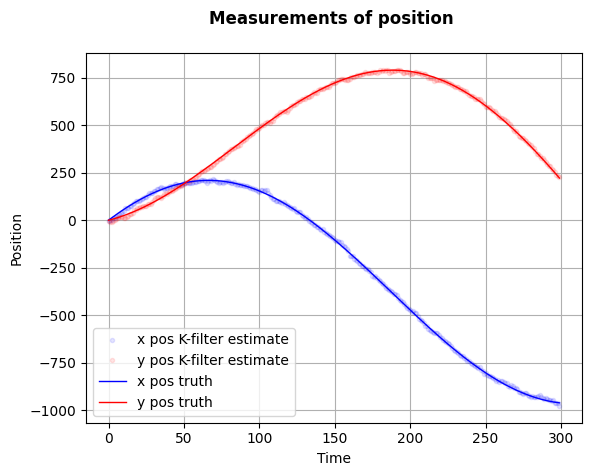

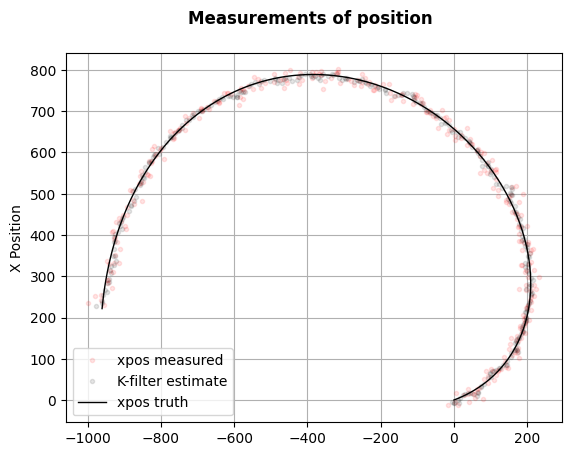

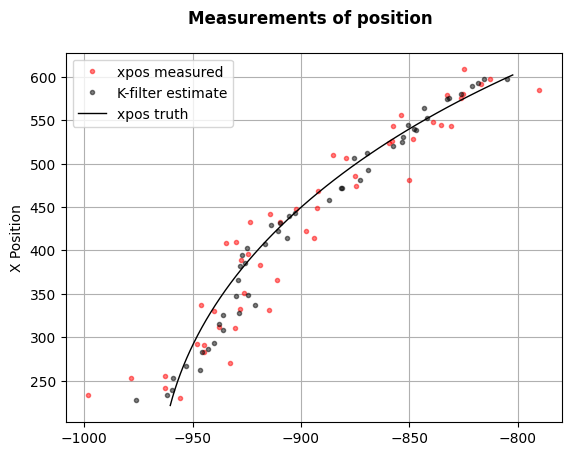

In [58]:
time, z, x, posBound3Sigma, mykalman = testFilter(gen_noisy_accel, n_meas)

measPos_x  = z[0, :]
measPos_y  = z[1, :]

estPos_x   = x[0, :]
estPos_y   = x[1, :]
estVel_x   = x[2, :]
estVel_y   = x[3, :]
estAccel_x = x[4, :]
estAccel_y = x[5, :]

plot1 = plt.figure(1)
plt.plot(time,    estPos_x,      'b.',  label='x pos K-filter estimate', alpha=0.1)
plt.plot(time,    estPos_y,      'r.',  label='y pos K-filter estimate', alpha=0.1)
plt.plot(time,    position_x,    'b',   label='x pos truth', lw=1)
plt.plot(time,    position_y,    'r',   label='y pos truth', lw=1)
plt.ylabel('Position')
plt.xlabel('Time')
plt.title('Measurements of position \n', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

plot1 = plt.figure(1)
plt.plot(measPos_x,   measPos_y,    'r.',  label='xpos measured', alpha=0.1)
plt.plot(estPos_x,    estPos_y,     'k.',  label='K-filter estimate', alpha=0.1)
plt.plot(position_x,  position_y,   'k',   label='xpos truth', lw=1)
plt.ylabel('Y Position')
plt.ylabel('X Position')
plt.title('Measurements of position \n', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()


plot1 = plt.figure(1)
ind = np.arange(250, 300)
plt.plot(measPos_x[ind],   measPos_y[ind],    'r.',  label='xpos measured', alpha=0.5)
plt.plot(estPos_x[ind],    estPos_y[ind],     'k.',  label='K-filter estimate', alpha=0.5)
plt.plot(position_x[ind],  position_y[ind],   'k',   label='xpos truth', lw=1)
plt.ylabel('Y Position')
plt.ylabel('X Position')
plt.title('Measurements of position \n', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()




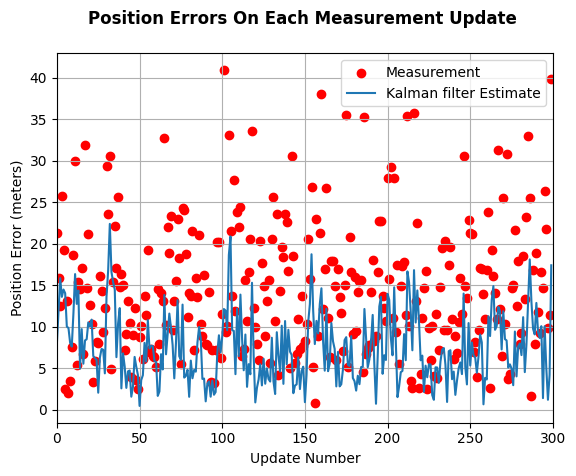

In [59]:
d_est  = np.abs(estPos_x-position_x  + 1.j*(estPos_y-position_y))
d_meas = np.abs(measPos_x-position_x + 1.j*(measPos_y-position_y))

plot3 = plt.figure(3)
plt.scatter(time, d_meas, color = 'red')
plt.plot(time,    d_est)
plt.legend(['Measurement', 'Kalman filter Estimate'])
plt.title('Position Errors On Each Measurement Update \n', fontweight="bold")
#plt.plot(t[0], t[6])
plt.ylabel('Position Error (meters)')
plt.xlabel('Update Number')
plt.grid(True)
plt.xlim([0, 300])
plt.show()